In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.optimize import linear_sum_assignment
import xgboost as xgb
from sklearn.model_selection import train_test_split

1. study time
2. failures
3. absencws
4. mother/father job
5. m/f edu

In [3]:
# Load the dataset
def load_data(filepath):
    """
    Load the student data from a CSV file.
    
    Parameters:
        filepath (str): The path to the CSV file.
    
    Returns:
        pd.DataFrame: Loaded data.
    """
    data = pd.read_csv(filepath)
    return data

# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data by dropping unnecessary columns and encoding categorical variables.
    
    Parameters:
        df (pd.DataFrame): The original dataframe.
    
    Returns:
        pd.DataFrame: Preprocessed dataframe.
    """
    # Drop 'G1' and 'G2' columns
    df = df.drop(['G1', 'G2'], axis=1)
    
    # Identify numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Exclude the target and treatment variables
    numeric_cols = [col for col in numeric_cols if col not in ['studytime', 'G3']]
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Define transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit and transform the data
    df_processed = preprocessor.fit_transform(df)
    
    # Get feature names after encoding
    encoded_cols = []
    if numeric_cols:
        encoded_cols += numeric_cols
    if categorical_cols:
        encoded_cols += preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
    
    # Convert to DataFrame
    df_processed = pd.DataFrame(df_processed, columns=encoded_cols)
    
    # Add treatment and outcome variables
    df_processed['studytime'] = df['studytime']
    df_processed['G3'] = df['G3']
    
    return df_processed


In [8]:
def define_treatment_binary(df, threshold=2):
    """
    Define the treatment variable based on 'studytime' as a binary variable.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.
        threshold (int): The threshold to define treated vs control.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['studytime'] > threshold, 1, 0)
    return df

def define_treatment_multiclass(df, thresholds=(1, 3)):
    """
    Define the treatment variable based on 'studytime' with multiple thresholds.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.
        thresholds (tuple): Thresholds to define treatment groups.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = pd.cut(
        df['studytime'],
        bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
        labels=[0, 1, 2]
    )
    return df


def train_uplift_models(df, feature_cols, treatment_col='treatment', outcome_col='G3'):
    """
    Train separate XGBoost models for treatment and control groups.
    
    Parameters:
        df (pd.DataFrame): The dataframe with covariates, treatment, and outcome.
        feature_cols (list): List of feature column names.
        treatment_col (str): The treatment column name.
        outcome_col (str): The outcome column name.
    
    Returns:
        model_treated: Trained XGBoost model for treated group.
        model_control: Trained XGBoost model for control group.
    """
    # Split data into treated and control
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    X_treated = treated[feature_cols]
    y_treated = treated[outcome_col]
    
    X_control = control[feature_cols]
    y_control = control[outcome_col]
    
    # Define XGBoost regressor
    model_treated = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model_control = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Train models
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    return model_treated, model_control

def predict_uplift(model_treated, model_control, X):
    """
    Predict uplift by taking the difference between treated and control model predictions.
    
    Parameters:
        model_treated: Trained XGBoost model for treated group.
        model_control: Trained XGBoost model for control group.
        X (pd.DataFrame): Feature matrix.
    
    Returns:
        pd.Series: Predicted uplift values.
    """
    pred_treated = model_treated.predict(X)
    pred_control = model_control.predict(X)
    uplift = pred_treated - pred_control
    return pd.Series(uplift, index=X.index)

def visualize_uplift(uplift):
    """
    Visualize the distribution of uplift scores.
    
    Parameters:
        uplift (pd.Series): Uplift scores.
    
    Returns:
        None
    """
    plt.figure(figsize=(8,6))
    sns.histplot(uplift, kde=True, bins=30)
    plt.xlabel('Uplift Score')
    plt.ylabel('Frequency')
    plt.title('Uplift Score Distribution')
    plt.show()


In [9]:
def compute_qini(qini_df, n_bins=10):
    """
    Compute the Qini coefficient for uplift modeling.

    Parameters:
        qini_df (pd.DataFrame): Dataframe containing 'uplift', 'G3', and 'treatment'.
        n_bins (int): Number of bins to divide the data.

    Returns:
        float: Qini coefficient.
    """
    # Sort by uplift in descending order
    qini_df_sorted = qini_df.sort_values(by='uplift', ascending=False).reset_index(drop=True)
    qini_df_sorted['rank'] = qini_df_sorted.index + 1

    # Assign to strata
    qini_df_sorted['stratum'] = pd.qcut(qini_df_sorted['rank'], q=n_bins, labels=False)

    # Calculate incremental gains per stratum
    qini_scores = []
    for stratum in range(n_bins):
        group = qini_df_sorted[qini_df_sorted['stratum'] == stratum]
        treated = group[group['treatment'] == 1]['G3']
        control = group[group['treatment'] == 0]['G3']
        treated_mean = treated.mean() if not treated.empty else 0
        control_mean = control.mean() if not control.empty else 0
        qini_scores.append(treated_mean - control_mean)

    # Calculate cumulative Qini
    qini_cumulative = np.cumsum(qini_scores)

    # Normalize Qini by the maximum possible
    max_qini = np.sum(sorted(qini_scores, reverse=True))
    qini = qini_cumulative[-1] / max_qini if max_qini != 0 else 0
    return qini

def evaluate_uplift_model(uplift, y_true, treatment):
    """
    Evaluate the uplift model using Qini coefficient.

    Parameters:
        uplift (pd.Series): Predicted uplift scores.
        y_true (pd.Series): True outcomes.
        treatment (pd.Series): Treatment assignments.

    Returns:
        float: Qini coefficient.
    """
    qini_df = pd.DataFrame({
        'uplift': uplift,
        'G3': y_true,
        'treatment': treatment
    })

    qini = compute_qini(qini_df)
    return qini

In [10]:
def run_uplift_model(filepath, treatment_def_func=define_treatment_binary, thresholds=(2), n_bins=10):
    """
    Run the Uplift Model workflow using XGBoost with the Two-Model Approach.

    Parameters:
        filepath (str): The path to the CSV file.
        treatment_def_func (function): Function to define the treatment variable.
        thresholds (tuple or int): Thresholds for treatment variable definition.
        n_bins (int): Number of bins for Qini coefficient calculation.

    Returns:
        None
    """
    # Load data
    df = load_data(filepath)

    # Preprocess data
    df_processed = preprocess_data(df)

    # Define treatment variable
    if treatment_def_func == define_treatment_binary:
        df_processed = treatment_def_func(df_processed, threshold=thresholds[0]) if isinstance(thresholds, tuple) else treatment_def_func(df_processed, threshold=thresholds)
    else:
        df_processed = treatment_def_func(df_processed, thresholds=thresholds)

    # If the treatment variable is defined as multi-category, choose one category for uplift modeling
    # Here we assume the treatment variable is binary; if multi-category, make adjustments as needed
    if df_processed['treatment'].dtype.name == 'category':
        # Example: Select category 1 as the primary treatment group, equivalent to binary
        df_processed = df_processed[df_processed['treatment'].isin([1])]
        df_processed['treatment'] = df_processed['treatment'].astype(int)

    # Define feature columns (exclude treatment and outcome variables)
    feature_cols = df_processed.columns.drop(['treatment', 'G3']).tolist()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        df_processed[feature_cols],
        df_processed['G3'],
        df_processed['treatment'],
        test_size=0.3,
        random_state=42
    )

    # Combine training data
    train_df = X_train.copy()
    train_df['G3'] = y_train
    train_df['treatment'] = treat_train

    # Train uplift models
    model_treated, model_control = train_uplift_models(train_df, feature_cols)

    # Predict uplift scores
    uplift = predict_uplift(model_treated, model_control, X_test)

    # Visualize uplift distribution
    visualize_uplift(uplift)

    # Evaluate the uplift model
    qini = evaluate_uplift_model(uplift, y_test, treat_test)
    print(f'Qini Coefficient: {qini:.4f}')

    print("\nUplift Modeling with XGBoost completed.")

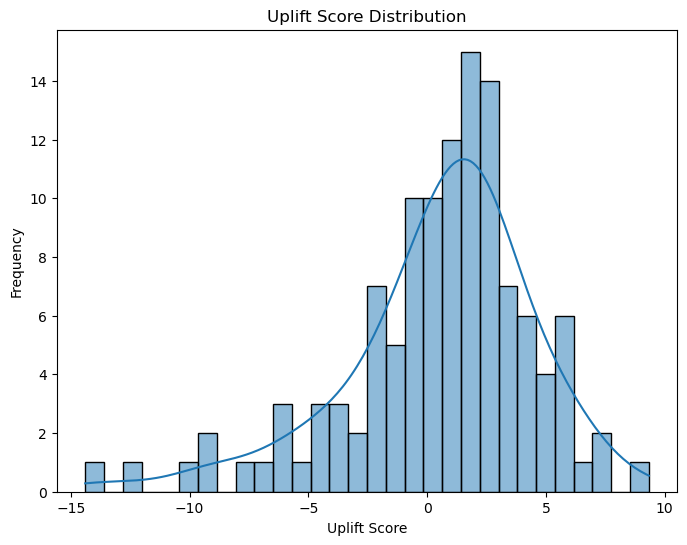

Qini Coefficient: 1.0000

Uplift Modeling with XGBoost completed.


In [11]:
if __name__ == "__main__":
    filepath = 'student_data.csv'
    
    run_uplift_model(
        filepath=filepath,
        treatment_def_func=define_treatment_binary,
        thresholds=2,  
        n_bins=10
    )